# pip install -U scikit-fuzzy

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

In [2]:
#設定顏色，以便後續透過顏色即可以識別分群結果
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown','ForestGreen']


In [3]:
#事先定義三群的中心點(質心)
centers = [[4, 2],
           [1, 7],
           [5, 6]]


In [4]:
#分別定義特徵x,特徵y的sigma值
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

In [61]:
#產生測試資料

#固定亂數種子
np.random.seed(42)

#定義array長度
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)

#建立常態分佈的測試資料
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    #labels用來過濾資料
    labels = np.hstack((labels, np.ones(200) * i))

In [6]:
#zip可以結合兩個list，輸出為tuple的list
list((zip(centers, sigmas)))

[([4, 2], [0.8, 0.3]), ([1, 7], [0.3, 0.5]), ([5, 6], [1.1, 0.7])]

In [7]:
#np.hstack可以結合兩個list，輸出為list
np.hstack(([1,2,3],[4,5,6,7]))

array([1, 2, 3, 4, 5, 6, 7])

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

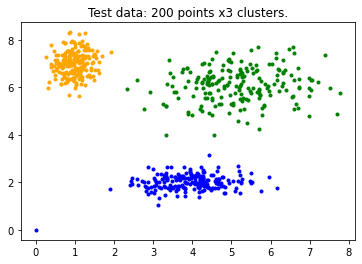

In [8]:
# Visualize the test data

fig0, ax0 = plt.subplots()
#畫出三群測試資料分佈
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.', color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

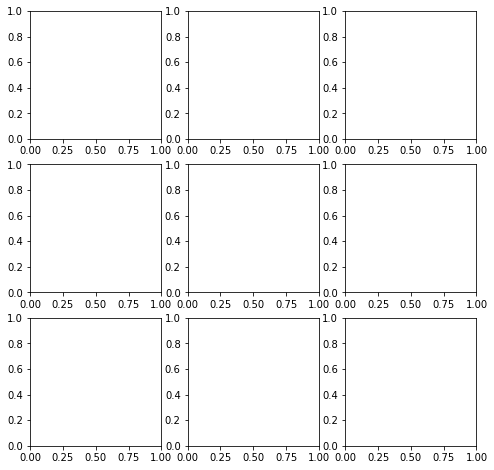

In [9]:
#假設我們不知道我們的訓練資料集應該分幾群(K值)
#我們採用的方法為FCM

#設定可以畫出9張圖(3x3)
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

In [10]:
#np.vstack可以結合兩個以上list，輸出為array
np.vstack(([1,2,3],[4,5,6],[7,8,9]))

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

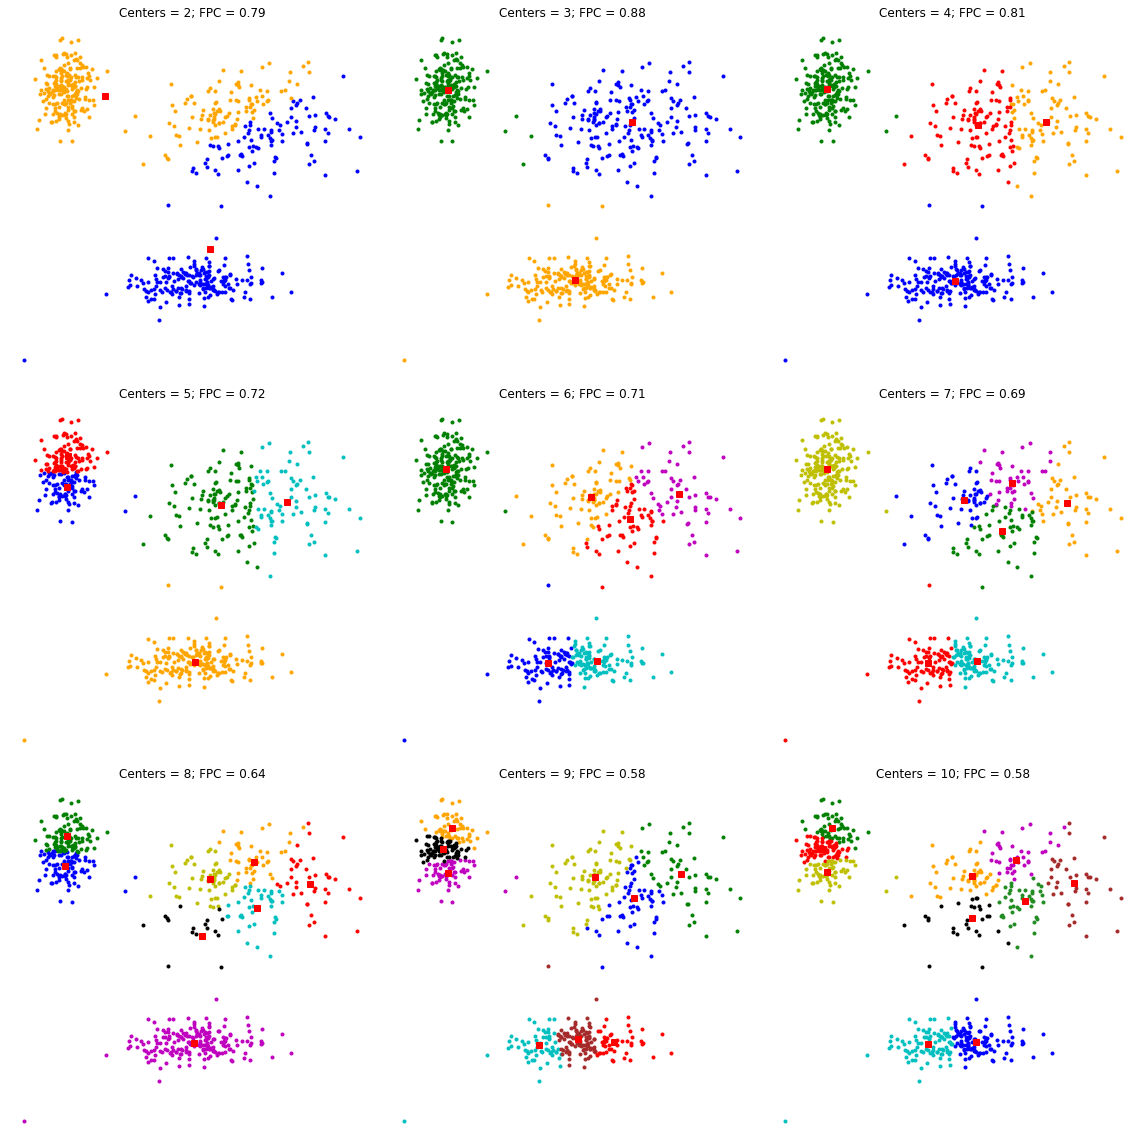

In [11]:
fig1, axes1 = plt.subplots(3, 3, figsize=(16, 16))
alldata = np.vstack((xpts, ypts))
fpcs = []

#enumerate會回傳兩個值，第一值為index順序，此範例由2開始依序回傳
for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    #調用fuzz.cluster.cmeans函數，依序為輸入訓練樣本資料集, 分群數量(K值), 更新隸屬值參數(此值可以調控該項對於群心計算的影響力), 停止條件, 最大迭代次數, 各群中心點初始值
    #回傳值: cntr: 各群中心點值
    #          u: 最終分群後的結果矩陣
    #         u0: 初始矩陣
    #          d: 最終歐式距離矩陣
    #         jm: 成本函數歷程
    #          p: 最終實際迭代次數
    #        fpc: 最終fcm參數
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    #儲存fcp
    fpcs.append(fpc)

    #找出每個樣本計算fcm結果後的最大值
    cluster_membership = np.argmax(u, axis=0)
    #將該樣本最大隸屬值對應到所屬的群
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    #將各群的中心點繪出，以利觀察
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

In [12]:
#np.argmax 找出最大值的index
print("陣列[1,2,3]最大值的index為:", np.argmax([1,2,3], axis=0))
print("2d矩陣[[1,2,3],[4,5,6]]最大值的index為:", np.argmax([[1,2,0],[4,5,6]], axis=1))

陣列[1,2,3]最大值的index為: 2
2d矩陣[[1,2,3],[4,5,6]]最大值的index為: [1 2]


Text(0, 0.5, 'Fuzzy partition coefficient')

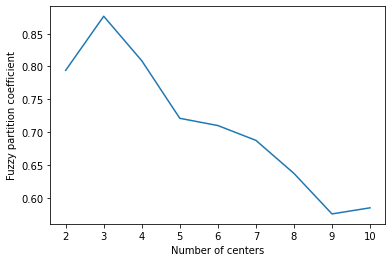

In [13]:
#fuzzy partition coefficient(FPC)為 0~1，該值越高表示分群效果越好
#事實上，我們建立的測試資料為3群資料，同時也對應下圖
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

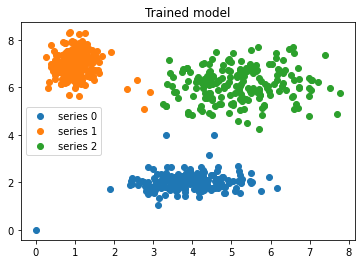

In [14]:
#重新建立一個3群的測試資料
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

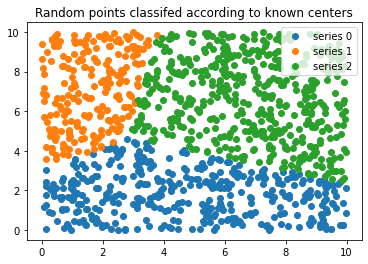

In [15]:
#預測新樣本資料

#建立測試資料集，由0~10之間，亂數產生2d資料 (1100x2)
newdata = np.random.uniform(0, 10, (1100, 2))

#預測
#newdata.T: 轉置矩陣
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)

#顯示結果
cluster_membership = np.argmax(u, axis=0)

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()


# 該套件參考自: https://pythonhosted.org/scikit-fuzzy/api/skfuzzy.cluster.html